In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import torchvision.transforms as transforms
import cv2
import numpy as np
import argparse
from PIL import Image

In [ ]:
label_color_map = [
               (0, 0, 0),  # background
               (128, 0, 0), # aeroplane
               (0, 128, 0), # bicycle
               (128, 128, 0), # bird
               (0, 0, 128), # boat
               (128, 0, 128), # bottle
               (0, 128, 128), # bus
               (128, 128, 128), # car
               (64, 0, 0), # cat
               (192, 0, 0), # chair
               (64, 128, 0), # cow
               (192, 128, 0), # dining table
               (64, 0, 128), # dog
               (192, 0, 128), # horse
               (64, 128, 128), # motorbike
               (192, 128, 128), # person
               (0, 64, 0), # potted plant
               (128, 64, 0), # sheep
               (0, 192, 0), # sofa
               (128, 192, 0), # train
               (0, 64, 128) # tv/monitor
]

In [ ]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

In [ ]:
def get_segment_labels(image, model, device):
    image = transform(image).to(device)
    image = image.unsqueeze(0)
    outputs = model(image)

    return outputs

In [ ]:
def draw_segmentation_map(outputs):
    labels = torch.argmax(outputs.squeeze(), dim=0).detach().cpu().numpy()
    red_map = np.zeros_like(labels).astype(np.uint8)
    green_map = np.zeros_like(labels).astype(np.uint8)
    blue_map = np.zeros_like(labels).astype(np.uint8)

    for label_num in range(0, len(label_color_map)):
        index = labels == label_num
        red_map[index] = np.array(label_color_map)[label_num, 0]
        green_map[index] = np.array(label_color_map)[label_num, 1]
        blue_map[index] = np.array(label_color_map)[label_num, 2]

    segmented_image = np.stack([red_map, green_map, blue_map], axis=2)
    return segmented_image

In [ ]:
def image_overlay(image, segmented_image):
    alpha = 0.6
    beta = 1 - alpha
    gamma = 0
    image = np.array(image)
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    segmented_image = cv2.cvtColor(segmented_image, cv2.COLOR_RGB2BGR)
    cv2.addWeighted(segmented_image, alpha, image, beta, gamma, image)
    return image

In [ ]:
#need to change file name every time different image is used
if 'get_ipython' in globals():
    args = {'input': '/content/input/image5.jpg'}
else:
    parser = argparse.ArgumentParser()
    parser.add_argument('-i', '--input', help='/content/input/image5.jpg')
    args = vars(parser.parse_args())


In [ ]:
model = torchvision.models.segmentation.fcn_resnet50(pretrained=True)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.eval().to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FCN_ResNet50_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=FCN_ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


FCN(
  (backbone): IntermediateLayerGetter(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequenti

In [ ]:
image = Image.open(args['input'])
outputs = get_segment_labels(image, model, device)
outputs = outputs['out']
print(outputs.shape)
segmented_image = draw_segmentation_map(outputs)

torch.Size([1, 21, 480, 640])


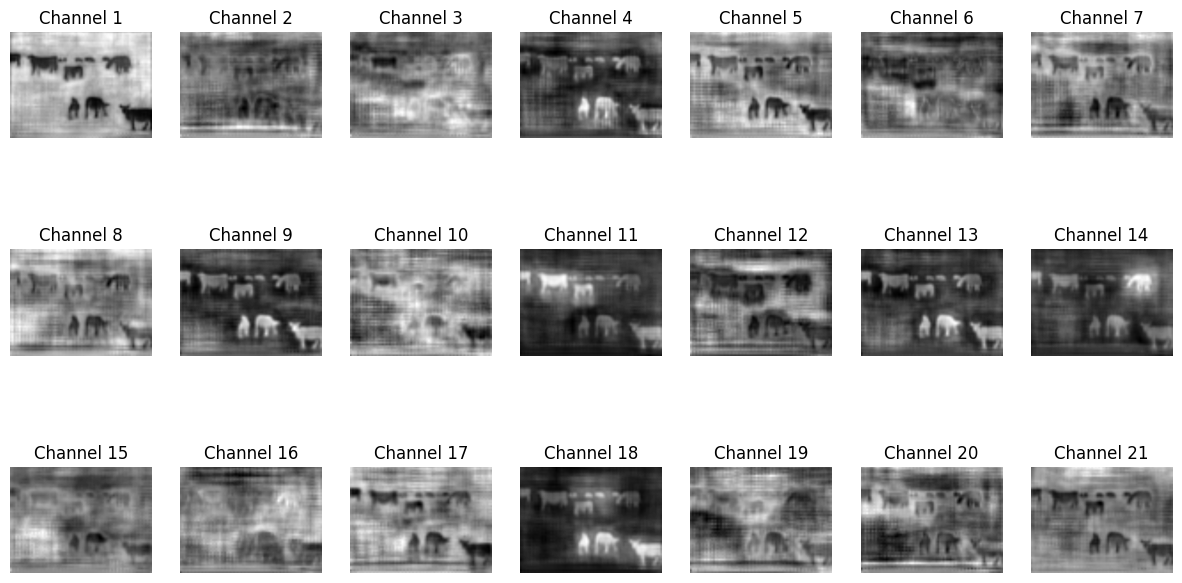

In [ ]:
import torch
import matplotlib.pyplot as plt

channels = outputs.squeeze(0)
fig, axes = plt.subplots(3, 7, figsize=(15, 8))

for i in range(21):
    row, col = divmod(i, 7)
    axes[row, col].imshow(channels[i].detach().cpu().numpy(), cmap='gray')
    axes[row, col].axis('off')
    axes[row, col].set_title(f'Channel {i + 1}')

plt.savefig("/content/featureMaps/featuremap5.jpg")
plt.show()

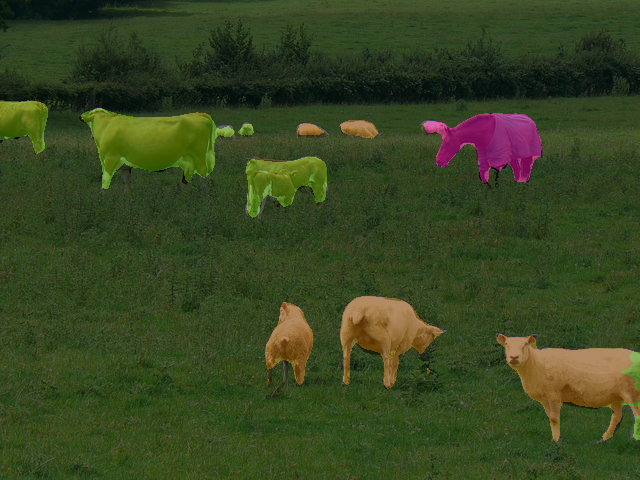

True

In [ ]:
from google.colab.patches import cv2_imshow

final_image = image_overlay(image, segmented_image)
save_name = f"{args['input'].split('/')[-1].split('.')[0]}"
cv2_imshow(final_image)
cv2.imwrite(f"/content/outputs/segmented_image5.jpg", final_image)